<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1725947133/Frame_10508.png" alt="Logo" width="40%">
  </a>
</div>


### 🖹 Descripción: 
Este notebook tiene como objetivo principal aplicar diversas técnicas de clasificación de datos en el conjunto de datos, titulado [Alzheimer Features](https://www.kaggle.com/datasets/brsdincer/alzheimer-features), el cual está enfocado en la clasificación binaria de pacientes con Alzheimer. Este conjunto fue seleccionado por su relevancia en la predicción de enfermedades neurológicas, utilizando datos tabulares para la creación de modelos diagnósticos eficaces. La elección de este conjunto se basa en su capacidad para enriquecer el análisis comparativo entre diferentes patologías, lo que permite profundizar en la aplicación de técnicas de clasificación en distintos contextos médicos.

### ✍️ Autores: 
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### 📅 Fecha: 
12 de septiembre de 2024

### 📝 Notas: 
Este notebook es el segundo de dos que forman parte del primer proyecto del curso IC6200 - Inteligencia Artificial. Este notebook está titulado "alzheimer", mientras que el siguiente se llama "diabetes".

### Otras notas:
- Asegurarse de que Python esté instalado, junto con las bibliotecas necesarias: pandas, numpy, matplotlib, seaborn, scipy, ydata_profiling, utils.


# 1. Importación de Librerías

In [1983]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from ydata_profiling import ProfileReport
from IPython.display import display, HTML

from enum import Enum
import random

import Utils as U
import importlib
importlib.reload(U)

<module 'Utils' from 'd:\\D\\TEC\\2024\\S2\\IA\\Repos\\IC6200_AI_P1\\src\\Utils.py'>

# 2. Definición de Constantes

In [1984]:
FILENAME_A = "./data/alzheimer.csv"

SHUFFLE_SEED = 153
COLOR_SEED = 666
PD_MAX_ROWS = 10
PD_MAX_WIDTH = 400

TRAINING_CUT = 0.7 # 70%
SCIKIT_LEARN_RANDOM_STATE = 73

# 3. Configuración ploteo pandas

In [1985]:
pd.set_option('display.max_rows', PD_MAX_ROWS)
pd.set_option('display.width', PD_MAX_WIDTH)
pd.set_option('future.no_silent_downcasting', True)

# 4. Definición de funciones auxiliares

In [1986]:
def print_column_types(df):
    print("Column types:")
    for column in df.columns:
        col_name = column.ljust(30)
        col_type = df[column].dtype
        print(f"{col_name} {col_type}")

def print_scores(y_true, y_pred):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Presition
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision:.2f}")
    
    # Recall
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {recall:.2f}")

    # F1 Score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.2f}")

    print()

# 5. Definición de estructuras auxiliares

In [1987]:
class Custom_Dataframe:
    def __init__(self, name, df, tag_col_name, features_col_names):
        self.name = name
        self.df = df
        self.tag_col_name = tag_col_name
        self.features_col_names = features_col_names


    def get_x(self):
        return self.df[self.features_col_names]


    def get_y(self):
        return self.df[self.tag_col_name]


    def cast_col(self, col_name, t: type):
        # t -> int, float, str
        self.df[col_name] = self.df[col_name].astype(t)


    def replace_col_values(self, replace_dict, col_name):
        df = self.df
        df[col_name] = df[col_name].replace(replace_dict)


    def append_col(self, new_col_name, new_col_values):
        self.df[new_col_name] = new_col_values


    def show_compare(self, y_pred):
        df_temp = pd.concat([pd.Series(self.df[self.tag_col_name].reset_index(drop=True), name='y_true'), pd.Series(y_pred, name='y_pred').reset_index(drop=True)], axis=1)
        print(df_temp)


    def reduce_dimesionality(self, columns_to_keep):
        self.df = self.df[columns_to_keep]
        columns_to_keep.remove(self.tag_col_name)
        self.features_col_names = columns_to_keep


    def remove_col_outliers(self, col_name):
        # IQR
        Q1 = self.df[col_name].quantile(0.25)
        Q3 = self.df[col_name].quantile(0.75)
        IQR = Q3 - Q1

        min_value = Q1 - 1.5 * IQR
        max_value = Q3 + 1.5 * IQR

        self.df = self.df[(self.df[col_name] >= min_value) & (self.df[col_name] <= max_value)]


    def remove_cols_outliers(self, col_names):
        for col_name in col_names:
            self.remove_col_outliers(col_name)


    def remove_NaN(self):
        self.df = self.df.dropna()


    def get_NaN(self):
        return self.df[self.df.isna().any(axis=1)]


    def get_NaN_by_count(self, NaN_count):
        return self.df[self.df.isnull().sum(axis=1) >= NaN_count]


    def show(self):
        print(self.name)
        print(self.df)

        # Check types
        print_column_types(self.df)

        print()

        # Check unique tags
        self.print_unique_tags()        
        print()
        print()


    def print_unique_tags(self):
        tags = self.df[self.tag_col_name].unique()
        print(f"Tags: {tags}")


    def print_tags_balance(self):
        print(self.name)
        total_rows = self.df.shape[0]
        print(f"Total rows = {total_rows}")
        tags = self.df[self.tag_col_name].unique()
        for tag in tags:
            count = self.df[self.df[self.tag_col_name] == tag].shape[0]
            percentage = 100 * count / total_rows
            formatted_percentage = "{:.2f}".format(percentage)
            print(f"Tag: {tag} -> {count} Rows ({formatted_percentage}%)")


class CYBERPUNK_COLORS(Enum):
    Red             = "#e74150"
    Yellow          = "#fee801"
    Green           = "#00ff9f"
    Dark_Blue       = "#005678"
    Night           = "#01012b"
    Cyan            = "#00ffe3"
    Red_Fuchsia     = "#ff1e61"
    Pink_Fuchsia    = "#ff008d"

    @classmethod
    def get_random_color(self, seed):
        random.seed(seed)        
        color_list = list(CYBERPUNK_COLORS)        
        selected_color = random.choice(color_list)
        return selected_color.value

    @classmethod
    def get_random_colormap(cls, seed=None):
        if seed is not None:
            random.seed(seed)        
        colormap_list = list(SEABORN_COLORMAPS)        
        selected_colormap = random.choice(colormap_list)
        return selected_colormap.value

# 6. Creación del dataframe principal

In [1988]:
# https://www.kaggle.com/datasets/brsdincer/alzheimer-features

def gen_cdf(filename, tag_col_name):
    filepath = Path(filename)

    # Checks read and the file
    if filepath.is_file():

        # Read .csv
        df = pd.read_csv(filepath)

        # Get non-tag columns
        features_col_names = [col for col in df.columns if col != tag_col_name]

        # Dataframe is shuffled to ease bias
        df = df.sample(frac=1, random_state=SHUFFLE_SEED).reset_index(drop=True)

        # Create Dataframe class instance
        cdf = Custom_Dataframe(filename, df, tag_col_name, features_col_names)
        #cdf.show()

        return cdf
    else:
        print(f"Need the file named: {filename}")

cdfa = gen_cdf(FILENAME_A, "Group")
cdfa.show()

./data/alzheimer.csv
           Group M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0       Demented   M   81    20  1.0  26.0  0.5  1556  0.691  1.128
1    Nondemented   M   85    12  3.0  30.0  0.0  1820  0.755  0.964
2    Nondemented   F   60    18  1.0  30.0  0.0  1402  0.822  1.252
3      Converted   M   84    16  2.0  30.0  0.0  1404  0.710  1.250
4       Demented   F   73    13  2.0  23.0  0.5  1536  0.725  1.142
..           ...  ..  ...   ...  ...   ...  ...   ...    ...    ...
368  Nondemented   F   84    16  3.0  28.0  0.0  1500  0.744  1.170
369  Nondemented   M   74    18  1.0  29.0  0.0  1814  0.679  0.967
370     Demented   M   70    16  3.0  29.0  0.5  1463  0.749  1.200
371  Nondemented   F   70    14  3.0  29.0  0.0  1524  0.787  1.151
372  Nondemented   F   77    16  2.0  29.0  0.0  1433  0.723  1.225

[373 rows x 10 columns]
Column types:
Group                          object
M/F                            object
Age                            int64
EDUC       

# 7. Manipulación preliminar de datos

## 7.1. Eliminación de clases no deseadas

En este caso se eliminaron las filas del dataset "Alzheimer" con la etiqueta "Converted".

In [1989]:
cdfa.df = cdfa.df[cdfa.df['Group'] != 'Converted']
cdfa.show()

./data/alzheimer.csv
           Group M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0       Demented   M   81    20  1.0  26.0  0.5  1556  0.691  1.128
1    Nondemented   M   85    12  3.0  30.0  0.0  1820  0.755  0.964
2    Nondemented   F   60    18  1.0  30.0  0.0  1402  0.822  1.252
4       Demented   F   73    13  2.0  23.0  0.5  1536  0.725  1.142
6       Demented   F   75    13  2.0  28.0  0.5  1520  0.708  1.155
..           ...  ..  ...   ...  ...   ...  ...   ...    ...    ...
368  Nondemented   F   84    16  3.0  28.0  0.0  1500  0.744  1.170
369  Nondemented   M   74    18  1.0  29.0  0.0  1814  0.679  0.967
370     Demented   M   70    16  3.0  29.0  0.5  1463  0.749  1.200
371  Nondemented   F   70    14  3.0  29.0  0.0  1524  0.787  1.151
372  Nondemented   F   77    16  2.0  29.0  0.0  1433  0.723  1.225

[336 rows x 10 columns]
Column types:
Group                          object
M/F                            object
Age                            int64
EDUC       

## 7.2. Convertir las columnas string del dataframe a números

Para la mayoría de los modelos, es necesario que los valores sean numéricos. En este caso tambien es necesario para generar la matriz de correlación.

In [1990]:
cdfa.replace_col_values({'Nondemented': 0, 'Demented': 1}, cdfa.tag_col_name)
cdfa.replace_col_values({'F': 0, 'M': 1}, "M/F")
cdfa.show()

./data/alzheimer.csv
    Group M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0       1   1   81    20  1.0  26.0  0.5  1556  0.691  1.128
1       0   1   85    12  3.0  30.0  0.0  1820  0.755  0.964
2       0   0   60    18  1.0  30.0  0.0  1402  0.822  1.252
4       1   0   73    13  2.0  23.0  0.5  1536  0.725  1.142
6       1   0   75    13  2.0  28.0  0.5  1520  0.708  1.155
..    ...  ..  ...   ...  ...   ...  ...   ...    ...    ...
368     0   0   84    16  3.0  28.0  0.0  1500  0.744  1.170
369     0   1   74    18  1.0  29.0  0.0  1814  0.679  0.967
370     1   1   70    16  3.0  29.0  0.5  1463  0.749  1.200
371     0   0   70    14  3.0  29.0  0.0  1524  0.787  1.151
372     0   0   77    16  2.0  29.0  0.0  1433  0.723  1.225

[336 rows x 10 columns]
Column types:
Group                          object
M/F                            object
Age                            int64
EDUC                           int64
SES                            float64
MMSE               

# 8. Exploratory Data Analysis (EDA)

## 8.1. Informe de correlación de características del Alzheimer

The file './reports/Alzheimer_Profiling_Report.html' already exists.
          Group       M/F       Age      EDUC       SES      MMSE       CDR      eTIV      nWBV       ASF
Group  1.000000  0.267781 -0.052000 -0.251761  0.164715 -0.611906  0.857218 -0.026625 -0.327277  0.020529
M/F    0.267781  1.000000 -0.063567  0.043633 -0.027069 -0.181244  0.205445  0.559698 -0.224322 -0.549123
Age   -0.052000 -0.063567  1.000000 -0.049768 -0.005012  0.045243 -0.033968  0.039135 -0.488989 -0.027714
EDUC  -0.251761  0.043633 -0.049768  1.000000 -0.733018  0.194574 -0.171576  0.257431  0.023647 -0.241982
SES    0.164715 -0.027069 -0.005012 -0.733018  1.000000 -0.135219  0.086957 -0.289781  0.048502  0.282657
MMSE  -0.611906 -0.181244  0.045243  0.194574 -0.135219  1.000000 -0.703969 -0.033561  0.370782  0.044231
CDR    0.857218  0.205445 -0.033968 -0.171576  0.086957 -0.703969  1.000000  0.009362 -0.350542 -0.016556
eTIV  -0.026625  0.559698  0.039135  0.257431 -0.289781 -0.033561  0.009362  1.0000

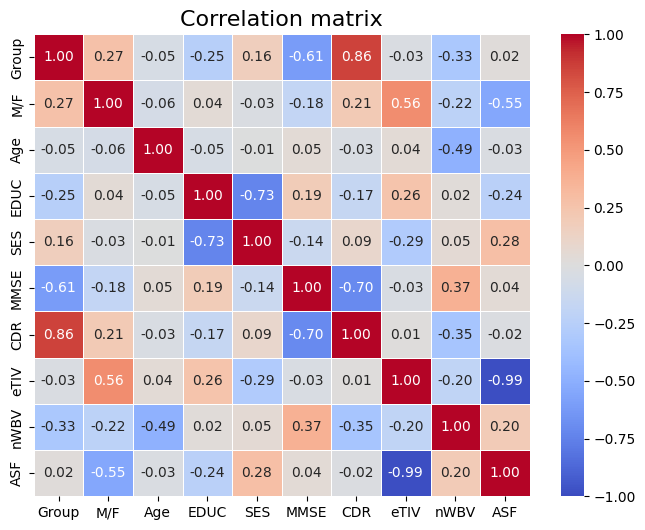

In [1991]:
def gen_correlation_report(cdf, report_name, cmap=False):
    if os.path.isfile(report_name):
        print(f"The file '{report_name}' already exists.")
    else:
        profile = ProfileReport(cdf.df, title="Alzheimer Profiling Report")
        profile.to_file(output_file=report_name)
        # display(HTML(file_name))

    # Access correlation matrix
    correlation_matrix = cdf.df.corr()
    print(correlation_matrix)

    if(cmap != False):
        # Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

        plt.title('Correlation matrix', fontsize=16)
        plt.show()

gen_correlation_report(cdfa, "./reports/Alzheimer_Profiling_Report.html", SEABORN_COLORMAPS.Coolwarm.value)

## 8.2. Visualización de relación entre características

In [1992]:
def generate_pairplot(df, tag):
    filename = 'reports/alzheimer_pairplot.png'
    filepath = Path(filename)
    if(filepath.is_file()):
        print('Image already generated in /reports')
    else:
        sns.pairplot(cdfa.df, hue=cdfa.tag_col_name)
        # plt.show()
        plt.savefig(filename, dpi=300)

generate_pairplot(cdfa.df, cdfa.tag_col_name)

Image already generated in /reports


## 8.3. Revisión del balance entre clases

Se verifican si las clases son adecuadas para la regresión logísticas y si están equilibradas.

In [1993]:
cdfa.print_tags_balance()

./data/alzheimer.csv
Total rows = 336
Tag: 1 -> 146 Rows (43.45%)
Tag: 0 -> 190 Rows (56.55%)


# 9. Manipulación del dataframe posterior al análisis

## 9.1. Reducción de dimensionalidad

In [1994]:
columns_to_keep = ['CDR', 'M/F', 'SES', 'Group']
cdfa.reduce_dimesionality(columns_to_keep)
cdfa.show()

./data/alzheimer.csv
     CDR M/F  SES Group
0    0.5   1  1.0     1
1    0.0   1  3.0     0
2    0.0   0  1.0     0
4    0.5   0  2.0     1
6    0.5   0  2.0     1
..   ...  ..  ...   ...
368  0.0   0  3.0     0
369  0.0   1  1.0     0
370  0.5   1  3.0     1
371  0.0   0  3.0     0
372  0.0   0  2.0     0

[336 rows x 4 columns]
Column types:
CDR                            float64
M/F                            object
SES                            float64
Group                          object

Tags: [1 0]




## 9.2. Conversion de tipos

In [1995]:
cdfa.cast_col('M/F', int)
cdfa.cast_col('Group', int)
cdfa.show()

./data/alzheimer.csv
     CDR  M/F  SES  Group
0    0.5    1  1.0      1
1    0.0    1  3.0      0
2    0.0    0  1.0      0
4    0.5    0  2.0      1
6    0.5    0  2.0      1
..   ...  ...  ...    ...
368  0.0    0  3.0      0
369  0.0    1  1.0      0
370  0.5    1  3.0      1
371  0.0    0  3.0      0
372  0.0    0  2.0      0

[336 rows x 4 columns]
Column types:
CDR                            float64
M/F                            int32
SES                            float64
Group                          int32

Tags: [1 0]




## 9.3. Revision de NaN/Nulos

In [1996]:
print("NaNs")
print(cdfa.get_NaN())

cdfa.remove_NaN()
cdfa.show()

NaNs
     CDR  M/F  SES  Group
11   0.5    0  NaN      1
29   1.0    1  NaN      1
46   0.5    1  NaN      1
93   0.5    1  NaN      1
115  0.5    1  NaN      1
..   ...  ...  ...    ...
309  0.5    0  NaN      1
322  0.5    1  NaN      1
330  1.0    1  NaN      1
342  1.0    0  NaN      1
346  0.5    0  NaN      1

[19 rows x 4 columns]
./data/alzheimer.csv
     CDR  M/F  SES  Group
0    0.5    1  1.0      1
1    0.0    1  3.0      0
2    0.0    0  1.0      0
4    0.5    0  2.0      1
6    0.5    0  2.0      1
..   ...  ...  ...    ...
368  0.0    0  3.0      0
369  0.0    1  1.0      0
370  0.5    1  3.0      1
371  0.0    0  3.0      0
372  0.0    0  2.0      0

[317 rows x 4 columns]
Column types:
CDR                            float64
M/F                            int32
SES                            float64
Group                          int32

Tags: [1 0]




## 9.4. Revision de outliers

In [1997]:
cdfa.remove_cols_outliers(['CDR', 'M/F', 'SES'])
cdfa.show()

./data/alzheimer.csv
     CDR  M/F  SES  Group
0    0.5    1  1.0      1
1    0.0    1  3.0      0
2    0.0    0  1.0      0
4    0.5    0  2.0      1
6    0.5    0  2.0      1
..   ...  ...  ...    ...
368  0.0    0  3.0      0
369  0.0    1  1.0      0
370  0.5    1  3.0      1
371  0.0    0  3.0      0
372  0.0    0  2.0      0

[314 rows x 4 columns]
Column types:
CDR                            float64
M/F                            int32
SES                            float64
Group                          int32

Tags: [1 0]




## 9.5. Revision de separabilidad de los datos

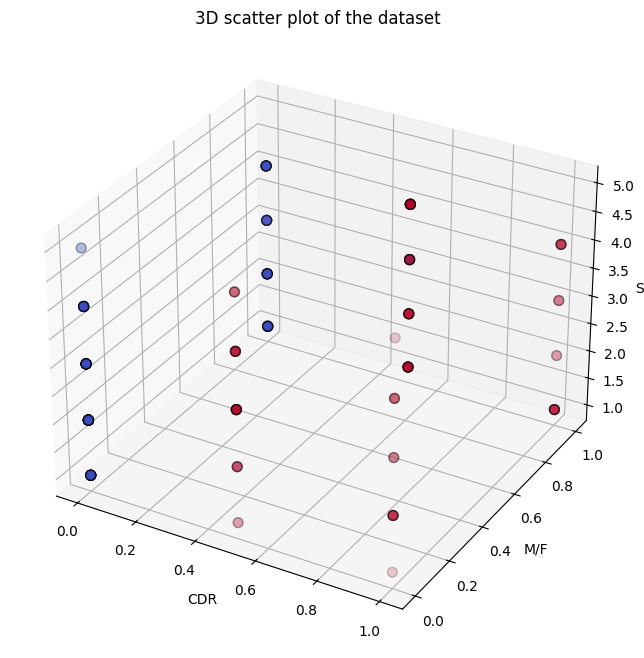

In [1998]:
# pd.set_option('display.max_rows', 800)
# print(cdfa.df[cdfa.df['CDR'] >= 0.5][cdfa.df['Group'] == 0])
#      CDR  M/F  SES  Group
# 54   0.5    1  3.0      0
# 144  0.5    1  4.0      0


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cdfa.df['CDR'], cdfa.df['M/F'], cdfa.df['SES'],
           c=cdfa.get_y(),
           cmap=U.SEABORN_COLORMAPS.COOLWARM.value,
           edgecolor='k',
           alpha=0.2,
           s=50)
ax.set_title('3D scatter plot of the dataset')
ax.set_xlabel('CDR')
ax.set_ylabel('M/F')
ax.set_zlabel('SES')
plt.show()

Es posible apreciar que existe una separabilidad casi total, sin embargo, se descubrió que al menos 2 valores no podrían ser separables por un plano en el espacio vectorial. A saber, las filas 54 y 144 del dataframe principal.

# 10. División del dataframe

In [1999]:
def tvt_df_split(df, test_size=0.3, validation_size=0.5, random_state=SCIKIT_LEARN_RANDOM_STATE):
    train_df, aux_df = train_test_split(df, test_size=test_size, random_state=random_state)
    validation_df, test_df = train_test_split(aux_df, test_size=validation_size, random_state=random_state)
    return train_df, validation_df, test_df

# Alzheimer custom dataframes
train_dfa, validation_dfa, test_dfa = tvt_df_split(cdfa.df)

train_cdfa = Custom_Dataframe(name="Alzheimer Training Custom Dataframe", df=train_dfa, tag_col_name=cdfa.tag_col_name, features_col_names=cdfa.features_col_names)
validation_cdfa = Custom_Dataframe(name="Alzheimer Validation Custom Dataframe", df=validation_dfa, tag_col_name=cdfa.tag_col_name, features_col_names=cdfa.features_col_names)
test_cdfa = Custom_Dataframe(name="Alzheimer Testing Custom Dataframe", df=test_dfa, tag_col_name=cdfa.tag_col_name, features_col_names=cdfa.features_col_names)

# pd.set_option('display.max_rows', 800)
train_cdfa.show()
validation_cdfa.show()
test_cdfa.show()

Alzheimer Training Custom Dataframe
     CDR  M/F  SES  Group
183  1.0    0  3.0      1
341  0.0    1  4.0      0
366  0.0    0  3.0      0
78   0.0    0  2.0      0
297  0.0    0  2.0      0
..   ...  ...  ...    ...
210  0.5    1  3.0      1
212  0.0    0  2.0      0
193  0.0    1  1.0      0
325  1.0    0  2.0      1
169  0.5    1  4.0      1

[219 rows x 4 columns]
Column types:
CDR                            float64
M/F                            int32
SES                            float64
Group                          int32

Tags: [1 0]


Alzheimer Validation Custom Dataframe
     CDR  M/F  SES  Group
293  0.0    0  2.0      0
334  0.0    0  1.0      0
303  0.0    0  5.0      0
261  0.5    1  2.0      1
260  0.5    1  1.0      1
..   ...  ...  ...    ...
166  0.5    1  4.0      1
139  1.0    1  3.0      1
294  0.0    0  3.0      0
132  0.0    0  2.0      0
343  0.0    0  2.0      0

[47 rows x 4 columns]
Column types:
CDR                            float64
M/F                  

## División en features y tags

In [2000]:
# Training
x_train = train_cdfa.get_x()
y_train = train_cdfa.get_y()

# Validation
x_val = validation_cdfa.get_x()
y_val = validation_cdfa.get_y()

# Test
x_true = test_cdfa.get_x()
y_true = test_cdfa.get_y()

# 11. KNN

## 11.1. Pruebas de KNN

Para estas pruebas los valores de k van desde 1 hasta 19.

In [2001]:
for k in range(1, 20, 2):

    knn_d = KNeighborsClassifier(n_neighbors=k)

    # Train
    knn_d.fit(x_train, y_train)
    # Validation
    y_pred_knn = knn_d.predict(x_val)

    # Scores
    print(f"---( k = {k} )---")
    print_scores(y_true=y_val, y_pred=y_pred_knn)

---( k = 1 )---
Accuracy: 0.94
Precision: 0.94
Recall: 0.89
F1 Score: 0.91

---( k = 3 )---
Accuracy: 0.91
Precision: 0.89
Recall: 0.89
F1 Score: 0.89

---( k = 5 )---
Accuracy: 0.91
Precision: 0.89
Recall: 0.89
F1 Score: 0.89

---( k = 7 )---
Accuracy: 0.91
Precision: 0.89
Recall: 0.89
F1 Score: 0.89

---( k = 9 )---
Accuracy: 0.94
Precision: 0.94
Recall: 0.89
F1 Score: 0.91

---( k = 11 )---
Accuracy: 0.94
Precision: 0.94
Recall: 0.89
F1 Score: 0.91

---( k = 13 )---
Accuracy: 0.94
Precision: 0.94
Recall: 0.89
F1 Score: 0.91

---( k = 15 )---
Accuracy: 0.94
Precision: 0.94
Recall: 0.89
F1 Score: 0.91

---( k = 17 )---
Accuracy: 0.89
Precision: 0.84
Recall: 0.89
F1 Score: 0.86

---( k = 19 )---
Accuracy: 0.89
Precision: 0.84
Recall: 0.89
F1 Score: 0.86



Basado en las pruebas anteriores se determina que el mejor k es igual a 1. Para este k sus métricas son:
* Accuracy = 0.94
* Precision = 0.94
* Recall = 0.89
* F1 Score = 0.91

## 11.2 Matriz de confusion

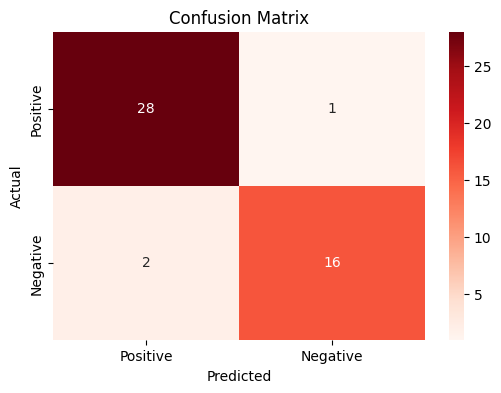

In [2002]:
knn_d = KNeighborsClassifier(n_neighbors=1)

# Train
knn_d.fit(x_train, y_train)
# Validation
y_pred_knn = knn_d.predict(x_val)

U.plot_confusion_matrix(y_true=y_val, y_pred=y_pred_knn, cmap=U.SEABORN_COLORMAPS.REDS.value)

# 12. Regresión Logística

## 12.1. Entrenamiento del modelo

In [2003]:
# Initialize and fit the logistic regression classifier
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(x_val)

# Evaluate the logistic regression model
print("Alzheimer Dataset - Logistic Regression Results:")
print_scores(y_true=y_val, y_pred=y_pred_log_reg)

Alzheimer Dataset - Logistic Regression Results:
Accuracy: 0.98
Precision: 0.95
Recall: 1.00
F1 Score: 0.97



## 12.2. Matriz de confusión

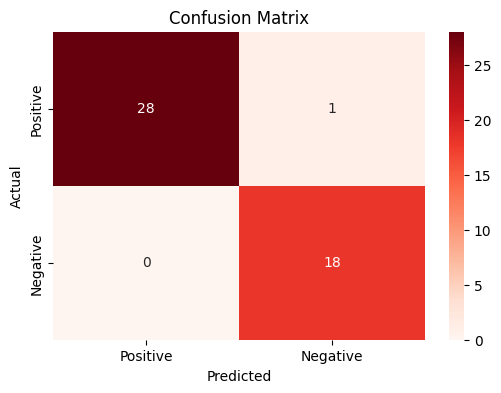

In [2004]:
U.plot_confusion_matrix(y_true=y_val, y_pred=y_pred_log_reg, cmap=U.SEABORN_COLORMAPS.REDS.value)

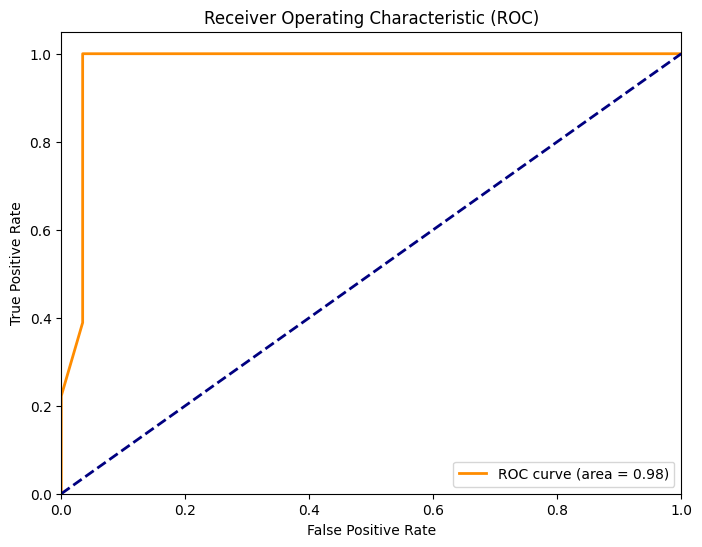

In [2005]:
y_pred_prob_log_reg = log_reg.predict_proba(x_val)[:, 1]
U.plot_ROC(y_true=y_val, y_pred_prob=y_pred_prob_log_reg)